In [1]:
import pandas as pd

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   policy_id       30 non-null     int64 
 1   driver_age      30 non-null     int64 
 2   driver_gender   30 non-null     object
 3   vehicle_age     30 non-null     int64 
 4   vehicle_type    30 non-null     object
 5   territory       30 non-null     object
 6   annual_mileage  30 non-null     int64 
 7   coverage_type   30 non-null     object
 8   premium         30 non-null     int64 
 9   claim_cost      30 non-null     int64 
 10  exposure        30 non-null     int64 
dtypes: int64(7), object(4)
memory usage: 2.7+ KB
Missing Values:
policy_id         0
driver_age        0
driver_gender     0
vehicle_age       0
vehicle_type      0
territory         0
annual_mileage    0
coverage_type     0
premium           0
claim_cost        0
exposure          0
dtype: int64


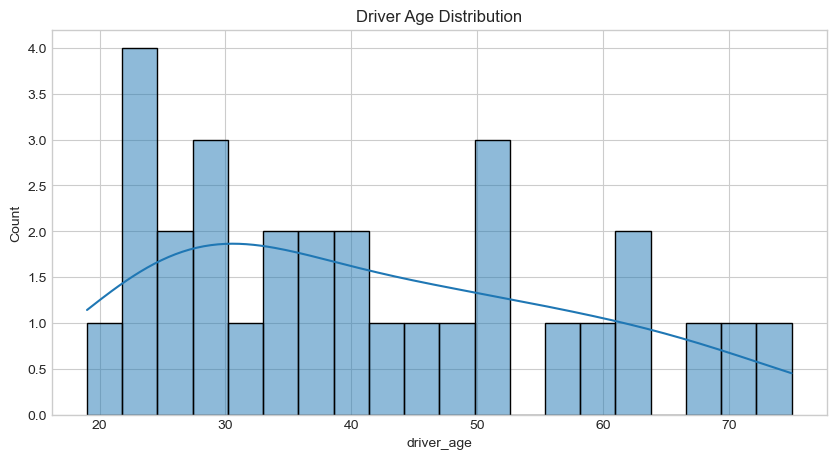

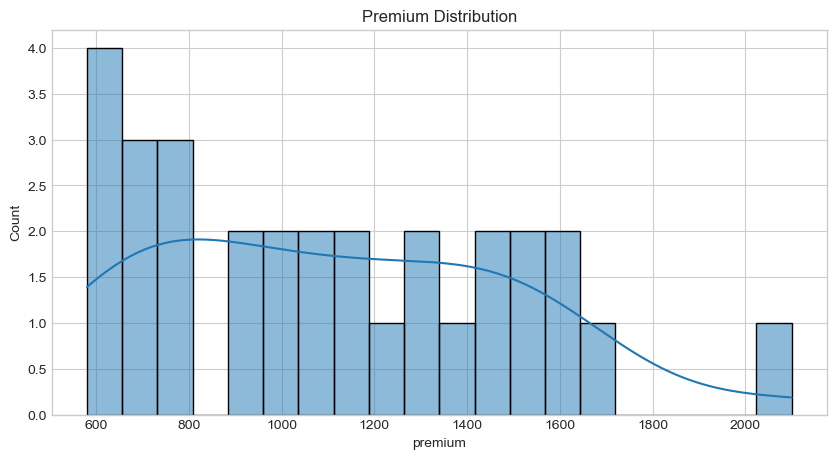

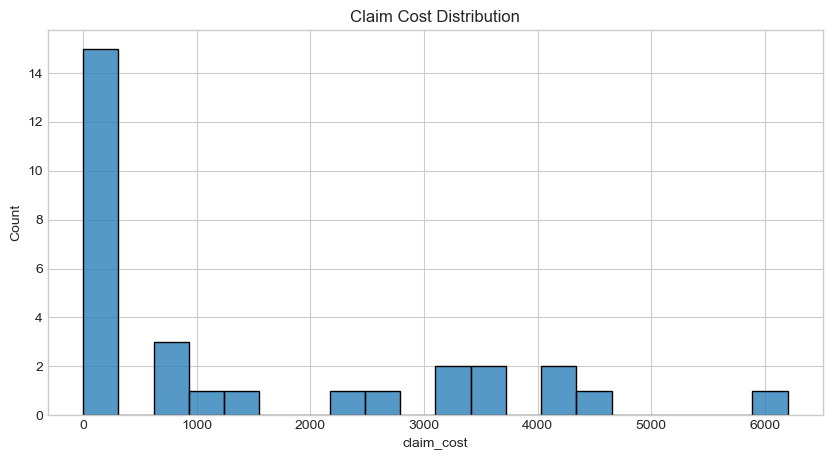

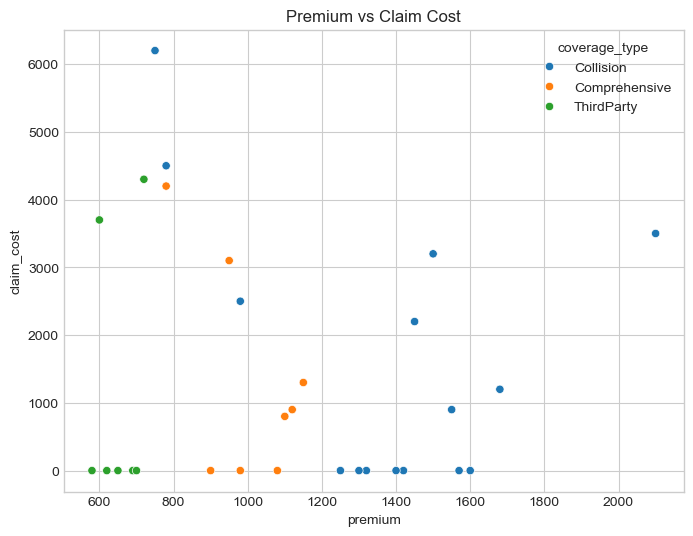

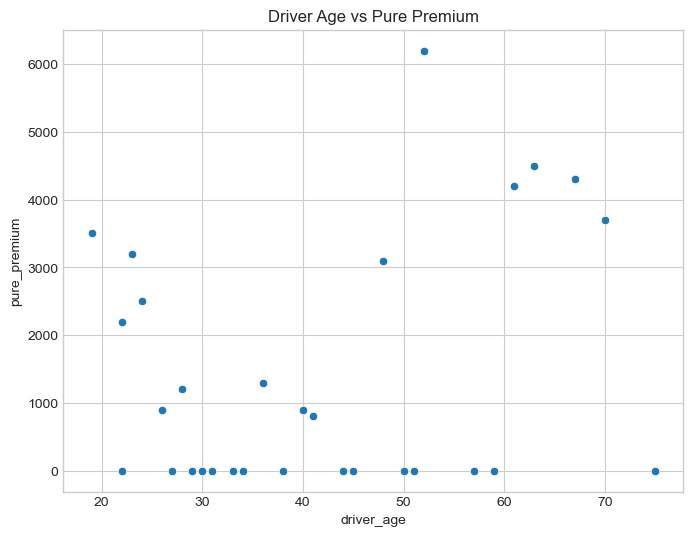

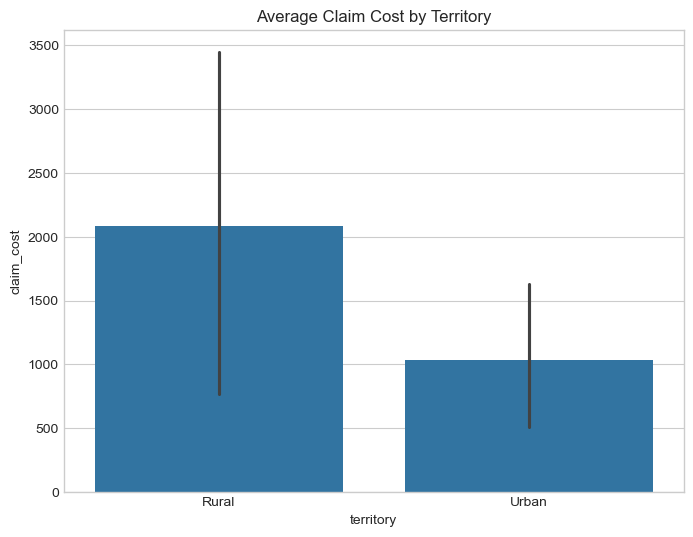

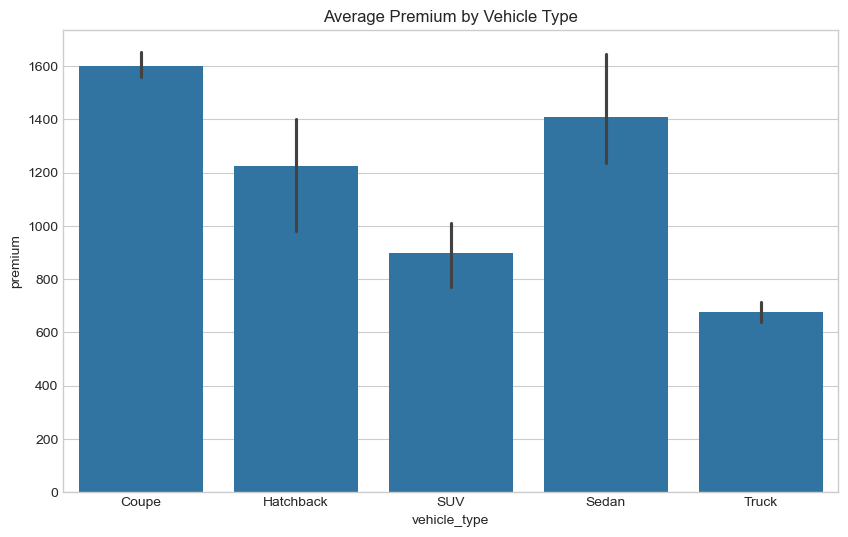

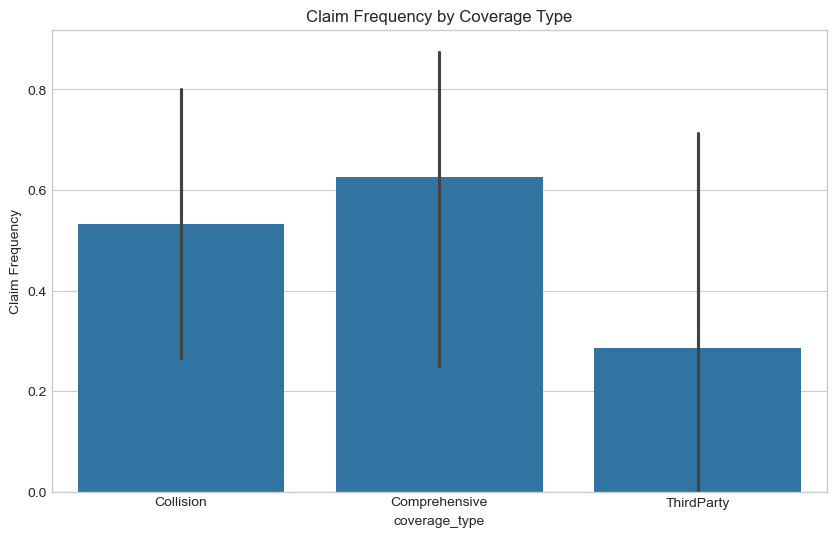

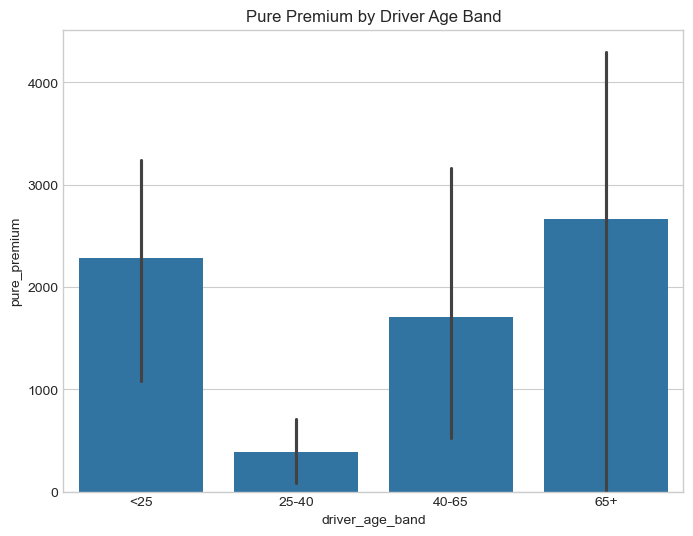

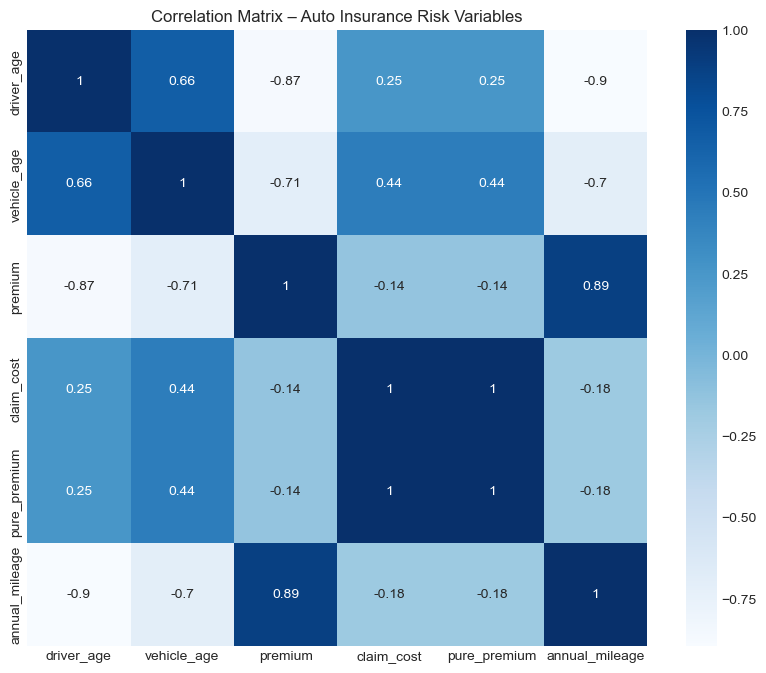

Data preprocessing complete and saved to data/processed.


In [9]:
# 01_exploratory_analysis.ipynb

# -----------------------------
# AUTO INSURANCE – EDA NOTEBOOK
# -----------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")

# -------------------------------------
# 1. Load the dataset
# -------------------------------------
df = pd.read_csv("C:/data/raw/auto_insurance_sample.csv")


# Preview dataset
df.head()
df.info()
df.describe()

# -------------------------------------
# 2. Basic Cleaning
# -------------------------------------
# Check missing values
print("Missing Values:")
print(df.isna().sum())

# Create pure premium (loss ratio proxy)
df["pure_premium"] = df["claim_cost"] / df["exposure"].replace(0, 1)

# Convert categorical variables
categorical_cols = ["driver_gender", "vehicle_type", "territory", "coverage_type"]
for col in categorical_cols:
    df[col] = df[col].astype("category")

df.head()

# -------------------------------------
# 3. Univariate Analysis
# -------------------------------------

# Driver age distribution
plt.figure(figsize=(10,5))
sns.histplot(df["driver_age"], bins=20, kde=True)
plt.title("Driver Age Distribution")
plt.show()

# Premium distribution
plt.figure(figsize=(10,5))
sns.histplot(df["premium"], bins=20, kde=True)
plt.title("Premium Distribution")
plt.show()

# Claim cost distribution
plt.figure(figsize=(10,5))
sns.histplot(df["claim_cost"], bins=20)
plt.title("Claim Cost Distribution")
plt.show()

# -------------------------------------
# 4. Bivariate Relationships
# -------------------------------------

# Premium vs Claim Cost
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="premium", y="claim_cost", hue="coverage_type")
plt.title("Premium vs Claim Cost")
plt.show()

# Driver age vs Pure Premium
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="driver_age", y="pure_premium")
plt.title("Driver Age vs Pure Premium")
plt.show()

# -------------------------------------
# 5. Categorical Comparisons
# -------------------------------------

# Claims by Territory
plt.figure(figsize=(8,6))
sns.barplot(data=df, x="territory", y="claim_cost", estimator=np.mean)
plt.title("Average Claim Cost by Territory")
plt.show()

# Premium by Vehicle Type
plt.figure(figsize=(10,6))
sns.barplot(data=df, x="vehicle_type", y="premium", estimator=np.mean)
plt.title("Average Premium by Vehicle Type")
plt.show()

# Claim frequency by Coverage Type
df["claim_flag"] = (df["claim_cost"] > 0).astype(int)

plt.figure(figsize=(10,6))
sns.barplot(data=df, x="coverage_type", y="claim_flag")
plt.title("Claim Frequency by Coverage Type")
plt.ylabel("Claim Frequency")
plt.show()

# -------------------------------------
# 6. Feature Engineering Setup
# -------------------------------------

# Driver age bands
df["driver_age_band"] = pd.cut(
    df["driver_age"],
    bins=[0, 25, 40, 65, 120],
    labels=["<25", "25-40", "40-65", "65+"]
)

# Vehicle age bands
df["vehicle_age_band"] = pd.cut(
    df["vehicle_age"],
    bins=[0, 5, 10, 20, 100],
    labels=["0-5", "5-10", "10-20", "20+"]
)

# Visualize age bands
plt.figure(figsize=(8,6))
sns.barplot(data=df, x="driver_age_band", y="pure_premium")
plt.title("Pure Premium by Driver Age Band")
plt.show()

# -------------------------------------
# 7. Correlation Heatmap (Numerical Only)
# -------------------------------------
plt.figure(figsize=(10,8))
sns.heatmap(df[["driver_age","vehicle_age","premium","claim_cost","pure_premium","annual_mileage"]].corr(),
            annot=True, cmap="Blues")
plt.title("Correlation Matrix – Auto Insurance Risk Variables")
plt.show()

# -------------------------------------
# 8. Save processed dataset
# -------------------------------------

df.to_csv("C:/data/auto_insurance_clean.csv", index=False)

print("Data preprocessing complete and saved to data/processed.")


GLM-Style Linear Regression Results
MAE: 1536.535114184511
R²: -1.8120166215358124

Random Forest Results
MAE: 1359.1666666666667
R²: -1.4121501488095238


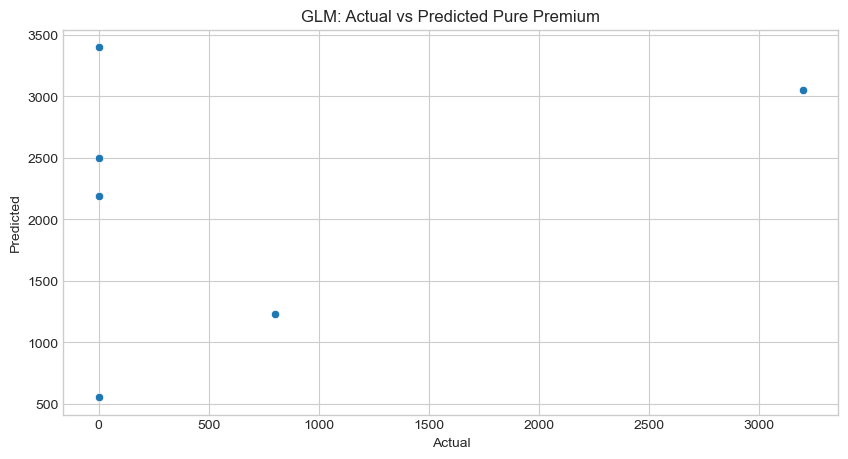

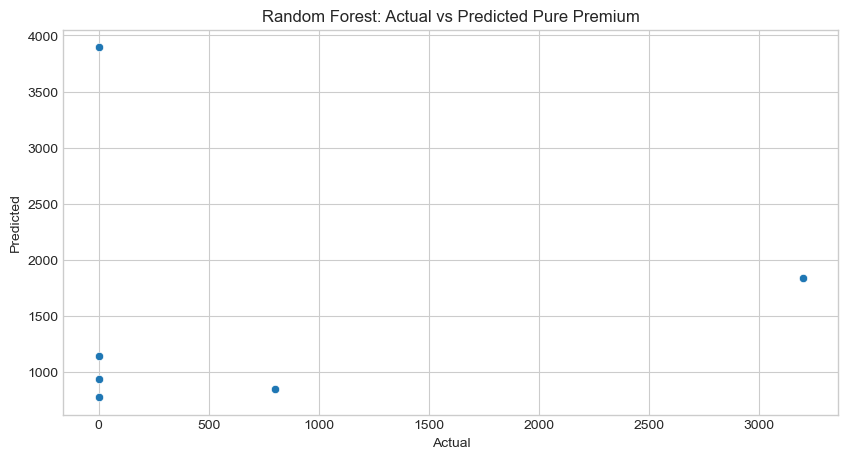


Predictions saved to data/processed/fairness_input.csv
Notebook 02 Complete.


In [2]:
# ----------------------------------------
# NOTEBOOK 02: AUTO INSURANCE PRICING MODEL
# ----------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

plt.style.use("seaborn-v0_8-whitegrid")

# ----------------------------------------
# 1. Load processed dataset
# ----------------------------------------

df = pd.read_csv("C:/data/auto_insurance_clean.csv")
df.head()

# ----------------------------------------
# 2. Modeling target variable
# ----------------------------------------
# Predict pure premium (loss per exposure)
df["pure_premium"] = df["claim_cost"] / df["exposure"].replace(0, 1)

# Slight stabilization (optional)
df["pure_premium_log"] = np.log1p(df["pure_premium"])

# ----------------------------------------
# 3. Select features for modeling
# ----------------------------------------
features = [
    "driver_age",
    "vehicle_age",
    "driver_gender",
    "vehicle_type",
    "territory",
    "coverage_type",
    "annual_mileage",
]

target = "pure_premium"

X = df[features]
y = df[target]

# ----------------------------------------
# 4. Train/Test Split
# ----------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ----------------------------------------
# 5. Preprocess categorical variables
# ----------------------------------------

categorical_features = ["driver_gender", "vehicle_type", "territory", "coverage_type"]
numeric_features = ["driver_age", "vehicle_age", "annual_mileage"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first"), categorical_features),
        ("num", "passthrough", numeric_features),
    ]
)

# ----------------------------------------
# 6. GLM-Style Linear Regression Model (Baseline)
# ----------------------------------------

glm_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LinearRegression())
    ]
)

glm_pipeline.fit(X_train, y_train)
glm_pred = glm_pipeline.predict(X_test)

glm_mae = mean_absolute_error(y_test, glm_pred)
glm_r2 = r2_score(y_test, glm_pred)

print("GLM-Style Linear Regression Results")
print("MAE:", glm_mae)
print("R²:", glm_r2)

# ----------------------------------------
# 7. Random Forest Model (Non-Linear Benchmark)
# ----------------------------------------

rf_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", RandomForestRegressor(n_estimators=300, random_state=42))
    ]
)

rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print("\nRandom Forest Results")
print("MAE:", rf_mae)
print("R²:", rf_r2)

# ----------------------------------------
# 8. Compare Predictions
# ----------------------------------------

comparison_df = pd.DataFrame({
    "actual": y_test.values,
    "glm_pred": glm_pred,
    "rf_pred": rf_pred
})

comparison_df.head()

# ----------------------------------------
# 9. Visualize Model Fit
# ----------------------------------------

plt.figure(figsize=(10,5))
sns.scatterplot(x=comparison_df["actual"], y=comparison_df["glm_pred"])
plt.title("GLM: Actual vs Predicted Pure Premium")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

plt.figure(figsize=(10,5))
sns.scatterplot(x=comparison_df["actual"], y=comparison_df["rf_pred"])
plt.title("Random Forest: Actual vs Predicted Pure Premium")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

# ----------------------------------------
# 10. Save predictions for Fairness Notebook
# ----------------------------------------

fairness_df = X_test.copy()
fairness_df["actual"] = y_test.values
fairness_df["glm_pred"] = glm_pred
fairness_df["rf_pred"] = rf_pred

"C:/data/auto_insurance_clean.csv"

fairness_df.to_csv("C:/data/fairness_input.csv", index=False)

print("\nPredictions saved to data/processed/fairness_input.csv")
print("Notebook 02 Complete.")
